In [ ]:
!pip install happytransformer
from IPython.display import clear_output
clear_output()

In [ ]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Colab Notebooks'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)

# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.config', 'gdrive', 'sample_data']


In [ ]:
import csv
from datasets import load_dataset
from happytransformer import TTSettings
from happytransformer import TTTrainArgs
from happytransformer import HappyTextToText

In [ ]:
#Model
happy_tt = HappyTextToText("T5", "t5-base")

In [ ]:
#Data collection
train_dataset = load_dataset("jfleg", split='validation[:]')
eval_dataset = load_dataset("jfleg", split='test[:]')

In [ ]:
#Data examination
for case in train_dataset["corrections"][:3]:
    print(case)
    print(case[0])
    print(" ")

In [ ]:
#Data preprocessing
replacements = [
  (" .", "."),
  (" ,", ","),
  (" '", "'"),
  (" ?", "?"),
  (" !", "!"),
  (" :", "!"),
  (" ;", "!"),
  (" n't", "n't"),
  (" 's'", "'s"),
  ("2 0 0 6", "2006"),
  ("5 5", "55"),
  ("4 0 0", "400"),
  ("1 7-5 0", "1750"),
  ("2 0 %", "20%"),
  ("5 0", "50"),
  ("1 2", "12"),
  ("1 0", "10"),
]

In [ ]:
def remove_excess_spaces(text):
  for rep in replacements:
    text = text.replace(rep[0], rep[1])
  return text

In [ ]:
def generate_csv(csv_path, dataset):
    with open(csv_path, 'w', newline='') as csvfile:
        writter = csv.writer(csvfile)
        writter.writerow(["input", "target"])
        for case in dataset:
     	    # Adding the task's prefix to input
            input_text = "grammar: " + case["sentence"]
            for correction in case["corrections"]:
                # a few of the cases contain blank strings.
                if input_text and correction:
                    input_text = remove_excess_spaces(input_text)
                    correction = remove_excess_spaces(correction)
                    writter.writerow([input_text, correction])

In [ ]:
generate_csv("train.csv", train_dataset)
generate_csv("eval.csv", eval_dataset)

In [ ]:
#Model evaluation before training
before_result = happy_tt.eval("eval.csv")

In [ ]:
print("Before training loss:", before_result.loss)

In [ ]:
#Training
args = TTTrainArgs(batch_size=8)
happy_tt.train("train.csv", args=args)

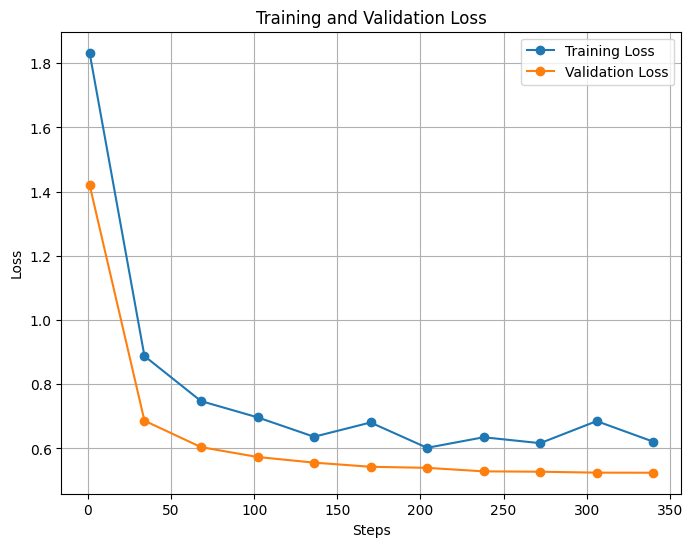

In [ ]:
import matplotlib.pyplot as plt

steps = [1, 34, 68, 102, 136, 170, 204, 238, 272, 306, 340]
training_loss = [1.832800, 0.887800, 0.747600, 0.697000, 0.636500, 0.680900, 0.602000, 0.634900, 0.616500, 0.685200, 0.621200]
validation_loss = [1.421111, 0.686403, 0.604200, 0.573451, 0.555834, 0.542946, 0.539567, 0.528704, 0.527548, 0.524651, 0.524414]

plt.figure(figsize=(8, 6))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#---------------------------------------------------------
#Save the model after training
happy_tt.save("gdrive/MyDrive/Colab Notebooks/model_pretrained")
#---------------------------------------------------------

In [ ]:
#Evaluation after training
after_loss = happy_tt.eval("eval.csv")

In [ ]:
print("After training loss: ", after_loss.loss)

In [ ]:
#---------------------------------------------------------
#Load a pretrained model
happy_tt = HappyTextToText("T5", "gdrive/MyDrive/Colab Notebooks/model_pretrained")
#---------------------------------------------------------

In [ ]:
#Inference
beam_settings =  TTSettings(num_beams=5, min_length=1, max_length=40)

In [ ]:
#Demo
example_1 = "grammar: This sentences, has bads grammar and spelling!"

result_1 = happy_tt.generate_text(example_1, args=beam_settings)
print(result_1.text)

This sentences, has bad grammar and spelling!


In [ ]:
example_2 = "grammar: I enjoy, writtings articles ons AI and I also enjoyed write articling on AI."

result_2 = happy_tt.generate_text(example_2, args=beam_settings)
print(result_2.text)

I enjoy writing articles on AI and I also enjoyed writing articles on AI.


In [ ]:
example_3 = "grammar: She like play in park and come here every month"

result_3 = happy_tt.generate_text(example_3, args=beam_settings)
print(result_3.text)

She likes to play in the park and comes here every month.
